<a href="https://colab.research.google.com/github/amyforza/Oxford-Figshare/blob/main/Pulling_Descriptive_Data_from_API_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2024-06-18 15:09:07.208 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


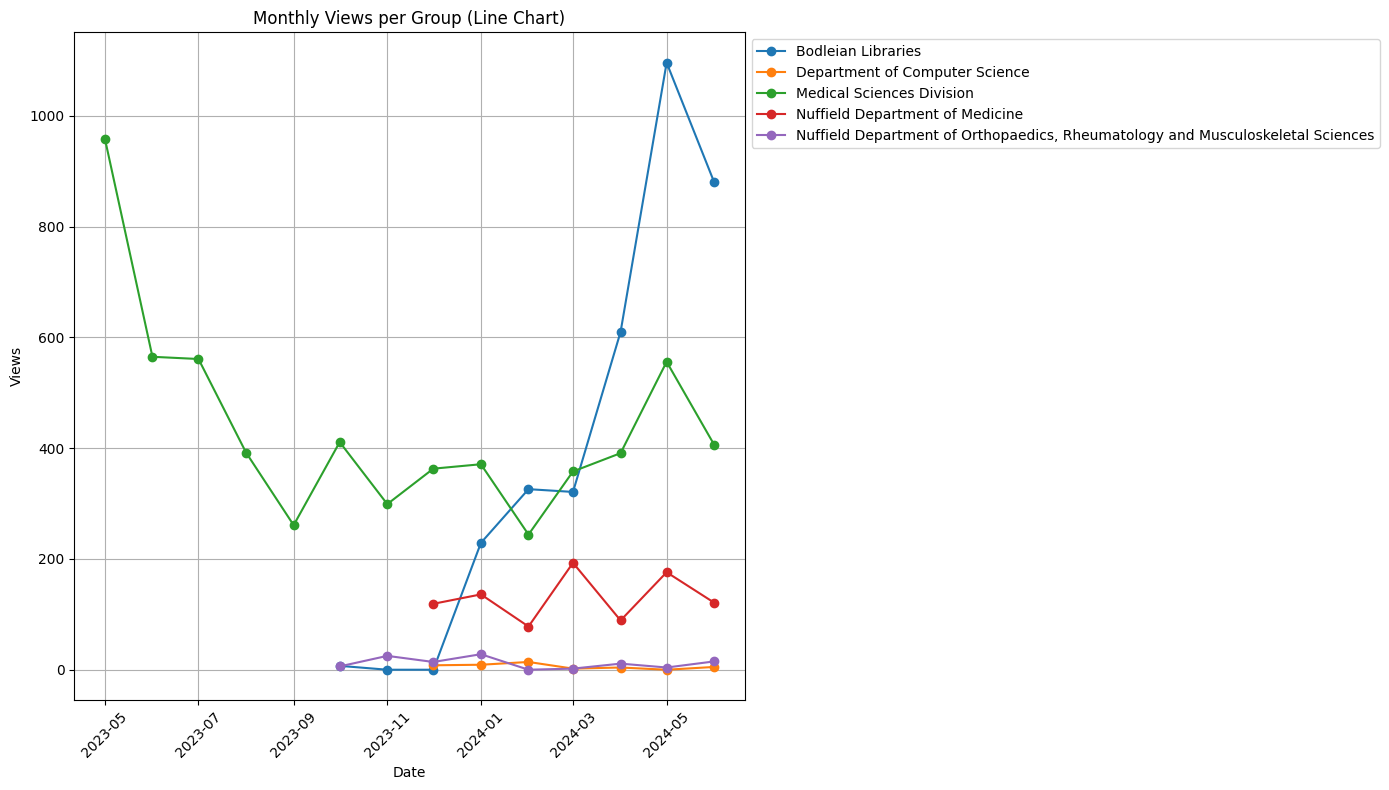

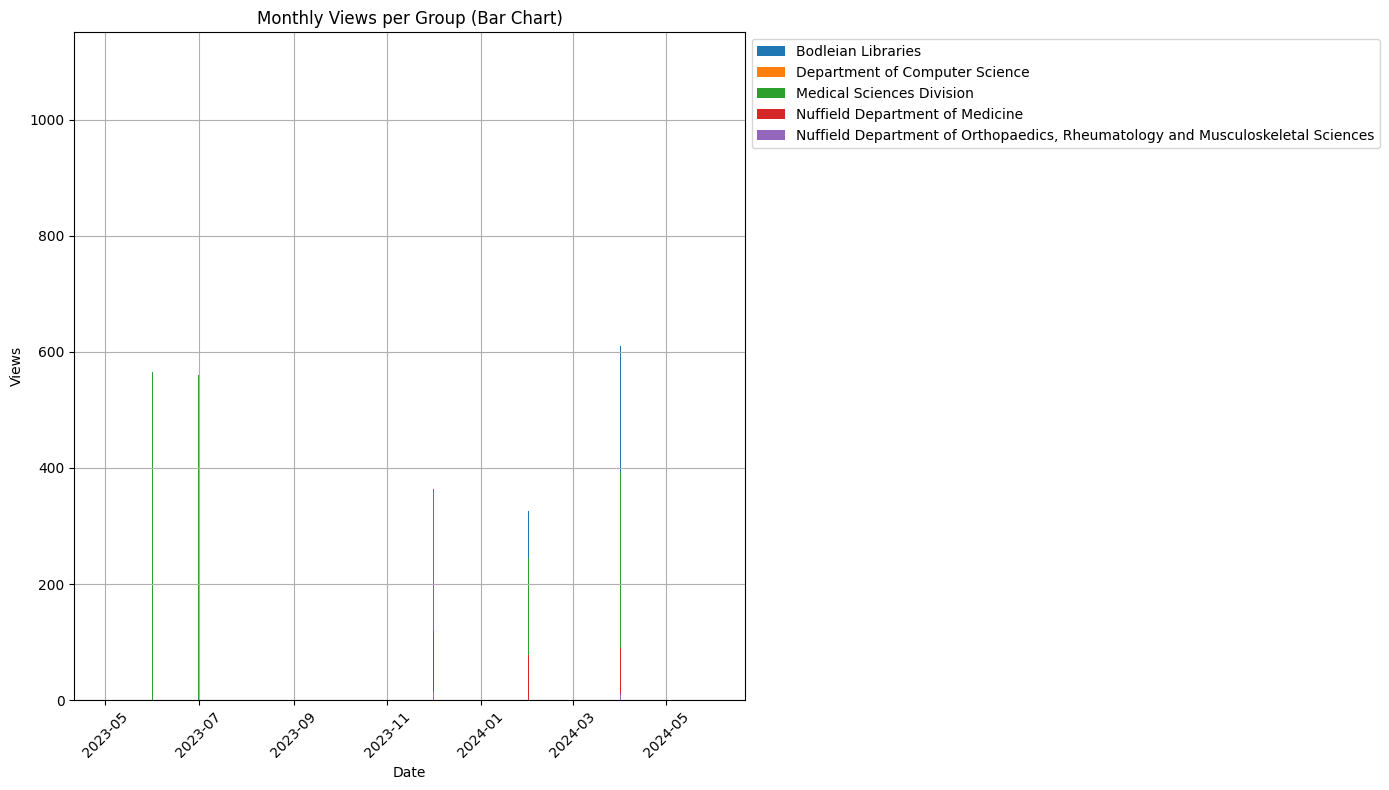

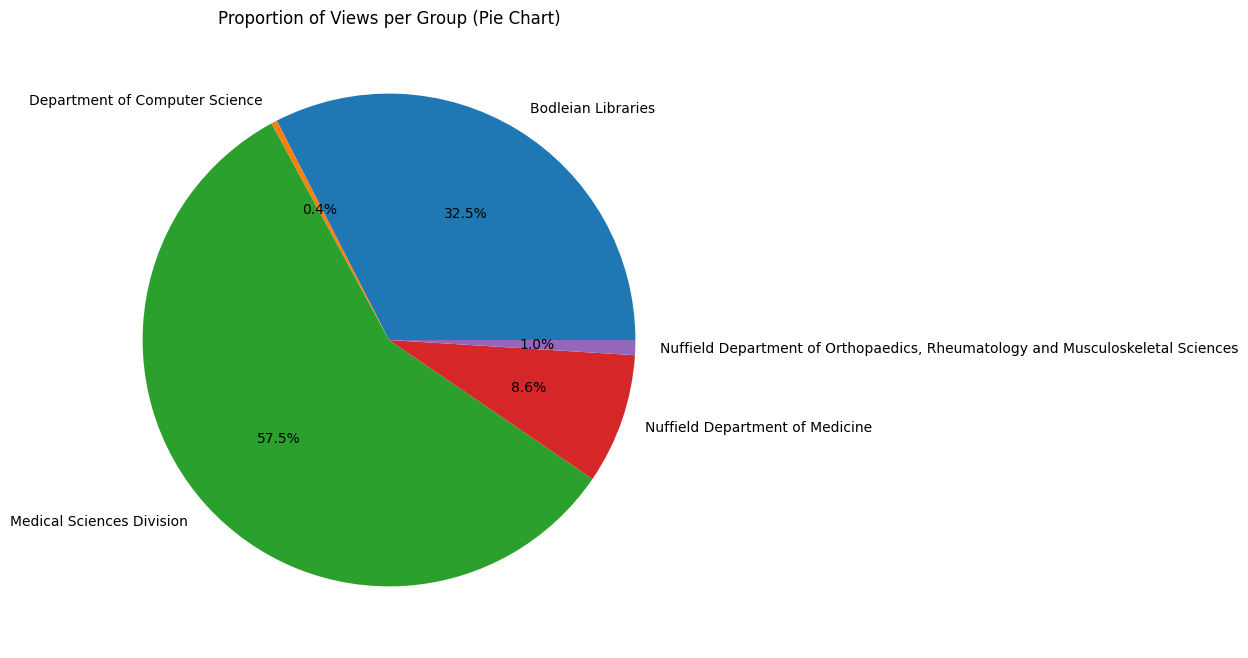

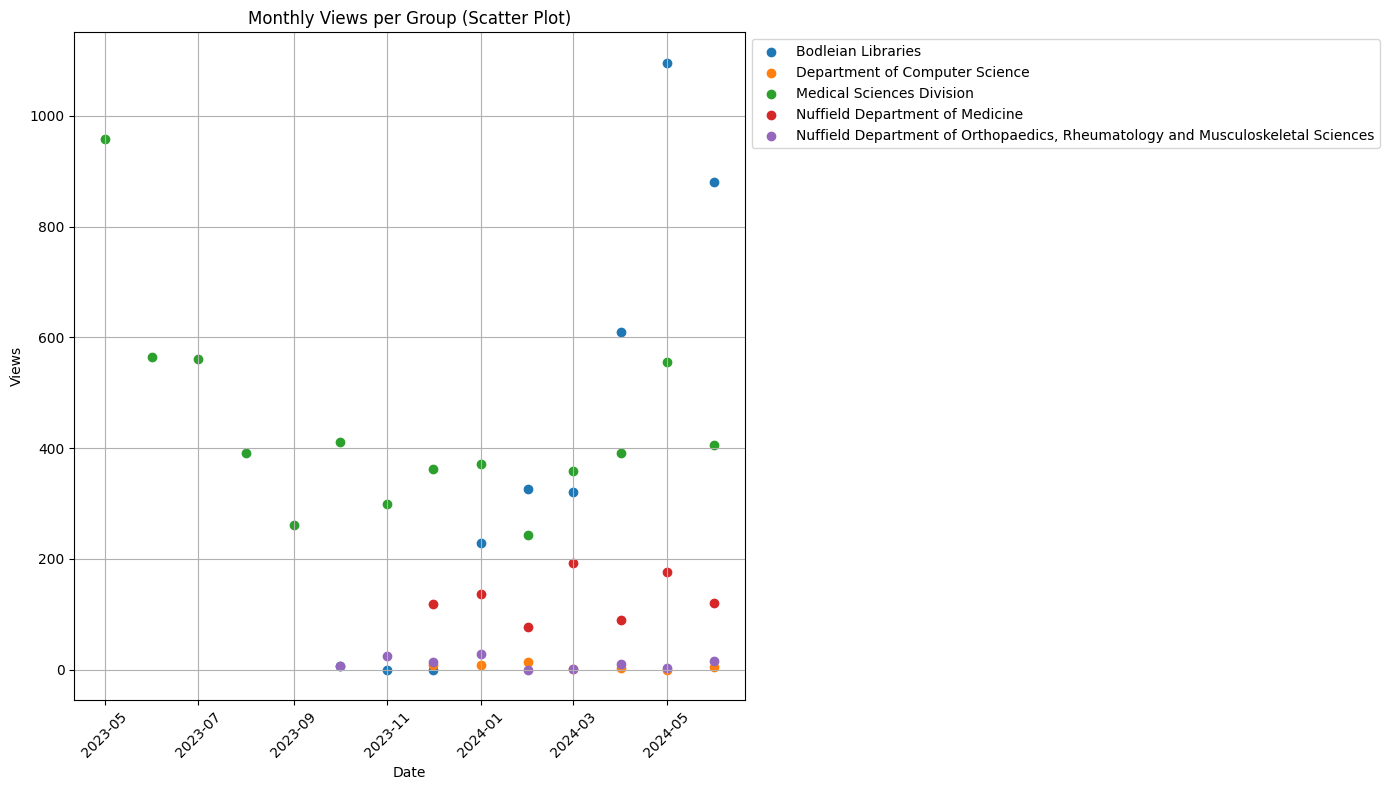

In [ ]:
import os
import streamlit as st
import requests
import base64
import pandas as pd
import matplotlib.pyplot as plt

# Authorization credentials
AUTH = os.getenv('OXFORD_STATS_API')
if AUTH is None:
    raise ValueError("OXFORD_STATS_API environment variable is not set")
INST = 'oxford'

# Encode the username and password
sample_string_bytes = AUTH.encode("ascii")
base64_bytes = base64.b64encode(sample_string_bytes)
base64_string = base64_bytes.decode("ascii")

api_call_headers2 = {'Authorization': 'Basic ' + base64_string}

# List of group IDs and names
group_dict = {
    47010: "Bodleian Libraries",
    47013: "Botanic Garden",
    47016: "History of Science Museum",
    47019: "Museum of Natural History",
    47022: "Pitt Rivers Museum",
    47025: "Department of Biology",
    47028: "Department of Chemistry",
    47031: "Chemical Biology",
    47034: "Chemistry Research Laboratory",
    47037: "Inorganic Chemistry",
    47040: "Organic Chemistry",
    47043: "Physical & Theoretical Chemistry",
    47046: "Department of Computer Science",
    47049: "Doctoral Training Centre - MPLS",
    47052: "Department of Earth Sciences",
    47055: "Department of Materials",
    47058: "Mathematical Institute",
    47061: "MPLS Division",
    47064: "Ineos Oxford Institute for Antimicrobial Research",
    47067: "Department of Statistics",
    47070: "Department of Physics",
    47073: "Astrophysics",
    47076: "Atmospheric, Oceanic and Planetary Physics",
    47079: "Atomic & Laser Physics",
    47082: "Condensed Matter Physics",
    47085: "Particle Physics",
    47088: "Theoretical Physics",
    47091: "Medical Sciences Division",
    47094: "Department of Biochemistry",
    47097: "Nuffield Department of Medicine",
    47100: "Nuffield Department of Clinical Neurosciences",
    47103: "Department of Experimental Psychology",
    47106: "Radcliffe Department of Medicine",
    47109: "Nuffield Department of Women's & Reproductive Health",
    47112: "Department of Oncology",
    47115: "Nuffield Department of Orthopaedics, Rheumatology and Musculoskeletal Sciences",
    47118: "Department of Paediatrics",
    47121: "Sir William Dunn School of Pathology",
    47124: "Department of Pharmacology",
    47127: "Department of Physiology, Anatomy and Genetics",
    47130: "Nuffield Department of Population Health",
    47133: "Nuffield Department of Primary Care Health Sciences",
    47136: "Department of Psychiatry",
    47139: "Nuffield Department of Surgical Sciences",
    48092: "Prismatic Jane Eyre",
    48295: "Griffith Institute",
    48298: "Egyptian Mirage",
    48301: "Levantine Mirage",
    48644: "Typhoid, Cockles, and Terrorism: The turbulent history of Anglo-Irish typhoid control in revolutionary Dublin",
    48668: "James Joyce Correspondence",
    48671: "James Joyce Correspondence: Letters",
    48674: "James Joyce Correspondence: People",
    49325: "War Collection",
    49328: "Lest We Forget",
    49421: "Bodleian Student Editions",
    50889: "Voltaire's pot-pourris",
    51456: "Oxford Facsimiles of Herculaneum Papyri",
    51651: "Sphakia survey",
    51654: "Sphakia survey videos",
    51657: "Sphakia survey images",
    51672: "Deep Roots of Racial Inequalities in US Healthcare",
    51714: "Sphakia survey documents",
    52774: "Lambert-David Collection",
    52854: "First World War Poetry Digital Archive",
    52863: "The Edward Thomas Collection",
    52869: "The Ivor Gurney Collection",
    52875: "The Robert Graves Collection",
    52881: "The Siegfried Sassoon Collection",
    52887: "The Wilfred Owen Collection",
    52890: "Publications of War",
    52893: "Great War Archive",
    52896: "War in Context",
    52899: "Oxford at War",
    52902: "Their Finest Hour",
    52995: "Lockdown2020 and beyond",
    53043: "Pandemic PACT",
    53229: "Oxford Health Histories",
    53492: "SDS self-help library",
    54324: "The Edmund Blunden Collection",
    54327: "The Vera Brittain Collection",
    54330: "The David Jones Collection",
    54333: "The Roland Leighton Collection",
    54336: "The Isaac Rosenberg Collection",
    54385: "Poetry Archive Documentation",
    54388: "Educational Resources",
    54475: "World War I Centenary: Continuations and Beginnings"
}

# Fetch timeline data for a given group ID
def fetch_timeline_data(inst, group_id):
    base_url = 'https://stats.figshare.com'
    endpoint = f'/{inst}/timeline/month/views/group/{group_id}'
    url = base_url + endpoint

    response = requests.get(url, headers=api_call_headers2)

    if response.status_code == 200:
        return response.json()
    else:
        st.error(f"Failed to retrieve data for group {group_id}: {response.status_code}")
        return None

# Create an empty DataFrame to store all results
all_timeline_data = pd.DataFrame()
failed_groups = []

# Loop through each group ID and fetch the timeline data
for group_id, group_name in group_dict.items():
    timeline_data = fetch_timeline_data(INST, group_id)

    if timeline_data and 'timeline' in timeline_data and timeline_data['timeline']:
        # Create a temporary DataFrame to store the group's timeline data
        temp_df = pd.DataFrame(timeline_data['timeline'].items(), columns=['Date', 'Views'])
        temp_df['Group ID'] = group_id
        temp_df['Group Name'] = group_name

        # Append the temporary DataFrame to the main DataFrame
        all_timeline_data = pd.concat([all_timeline_data, temp_df], ignore_index=True)
    else:
        failed_groups.append(group_id)

# Ensure 'Date' column is in datetime format
all_timeline_data['Date'] = pd.to_datetime(all_timeline_data['Date'])

# Filter out groups with no data from the group_dict
available_groups = {k: v for k, v in group_dict.items() if k not in failed_groups}

# Streamlit app
st.title("Oxford Stats Dashboard")

selected_groups = st.multiselect(
    'Select Groups',
    options=list(available_groups.values()),
    default=list(available_groups.values())[:5]
)

if 5 <= len(selected_groups) <= 10:
    selected_group_ids = [key for key, value in available_groups.items() if value in selected_groups]

    # Plot functions
    def plot_line_chart():
        plt.figure(figsize=(14, 8))
        for group_id in selected_group_ids:
            group_data = all_timeline_data[all_timeline_data['Group ID'] == group_id]
            plt.plot(group_data['Date'], group_data['Views'], marker='o', label=group_dict[group_id])
        plt.xticks(rotation=45)
        plt.title("Monthly Views per Group (Line Chart)")
        plt.xlabel("Date")
        plt.ylabel("Views")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True)
        plt.tight_layout()
        st.pyplot(plt)

    def plot_bar_chart():
        plt.figure(figsize=(14, 8))
        bar_width = 0.3  # Adjust the bar width for thicker bars
        for group_id in selected_group_ids:
            group_data = all_timeline_data[all_timeline_data['Group ID'] == group_id]
            plt.bar(group_data['Date'], group_data['Views'], bar_width, label=group_dict[group_id])
        plt.xticks(rotation=45)
        plt.title("Monthly Views per Group (Bar Chart)")
        plt.xlabel("Date")
        plt.ylabel("Views")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True)
        plt.tight_layout()
        st.pyplot(plt)

    def plot_pie_chart():
        plt.figure(figsize=(8, 8))
        total_views = all_timeline_data[all_timeline_data['Group ID'].isin(selected_group_ids)].groupby('Group Name')['Views'].sum()
        total_views.plot(kind='pie', autopct='%1.1f%%')
        plt.title("Proportion of Views per Group (Pie Chart)")
        plt.ylabel('')
        st.pyplot(plt)

    def plot_scatter_plot():
        plt.figure(figsize=(14, 8))
        for group_id in selected_group_ids:
            group_data = all_timeline_data[all_timeline_data['Group ID'] == group_id]
            plt.scatter(group_data['Date'], group_data['Views'], label=group_dict[group_id])
        plt.xticks(rotation=45)
        plt.title("Monthly Views per Group (Scatter Plot)")
        plt.xlabel("Date")
        plt.ylabel("Views")
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.grid(True)
        plt.tight_layout()
        st.pyplot(plt)

    # Display plots
    st.subheader("Line Chart")
    plot_line_chart()

    st.subheader("Bar Chart")
    plot_bar_chart()

    st.subheader("Pie Chart")
    plot_pie_chart()

    st.subheader("Scatter Plot")
    plot_scatter_plot()
else:
    st.error("Please select between 5 and 10 groups.")
